# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
conditions = ['human', 'chimp', 'macaque', 'spatial_libd_human']
cond_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
color_dict = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'spatial_libd_human': 'tab:blue'}

# Load files

## Pseudobulks

### Load

In [8]:
dir_path = '../../data/pseudobulks/'

In [9]:
os.listdir(dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'adults_mammals.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_new.h5ad',
 'pb_mammals_new_sum.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad',
 'pb_mammals_sum.h5ad']

In [10]:
adata_pb_adult = sc.read_h5ad(dir_path + 'pb_age.h5ad')
adata_pb_adult

AnnData object with n_obs × n_vars = 111 × 17919
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [11]:
adata_pb_mamm = sc.read_h5ad(dir_path + 'pb_mammals.h5ad')
adata_pb_mamm

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

### Preprocess

Merge newborn and adult data

In [12]:
adata_merged = an.concat([adata_pb_mamm, adata_pb_adult[adata_pb_adult.obs.condition != 'human']], merge='same')
adata_merged

AnnData object with n_obs × n_vars = 170 × 14611
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [13]:
adata_merged.write_h5ad("results/adults_mammals.h5ad")

Normalize

In [14]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

normalizing counts per cell
    finished (0:00:00)


computing PCA
    with n_comps=34
    finished (0:00:00)


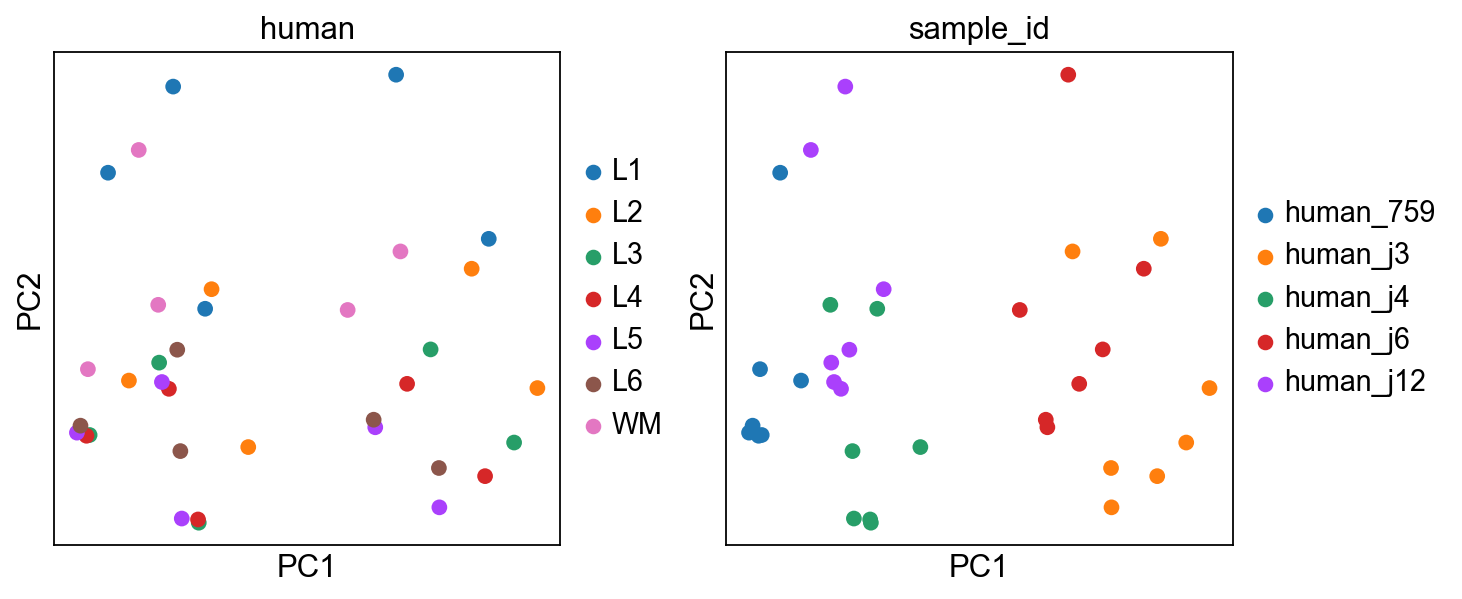

computing PCA
    with n_comps=30
    finished (0:00:00)


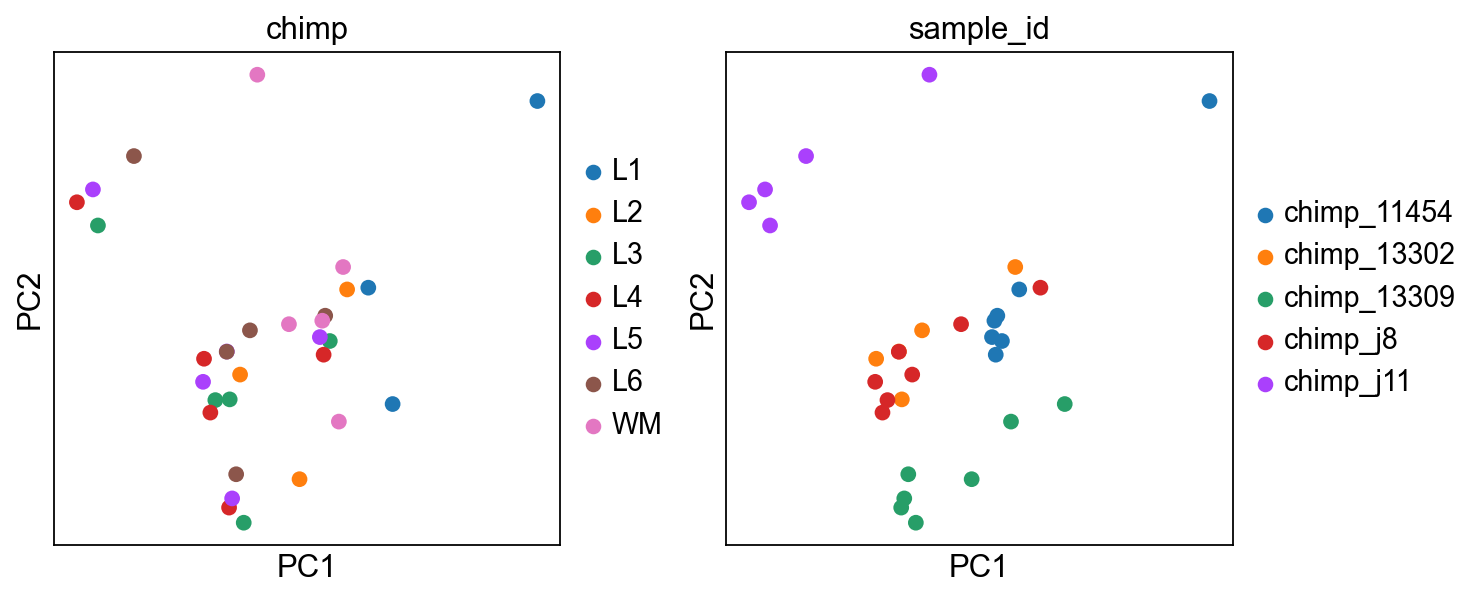

computing PCA
    with n_comps=27
    finished (0:00:00)


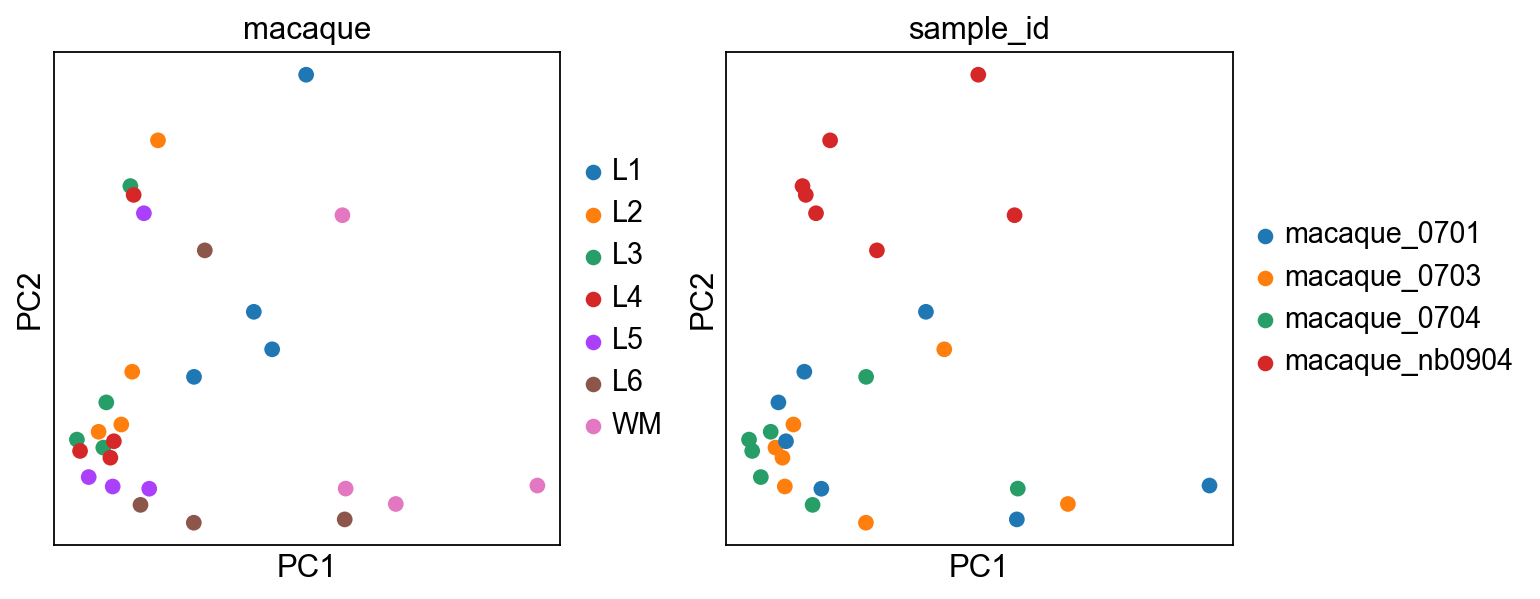

computing PCA
    with n_comps=50
    finished (0:00:00)


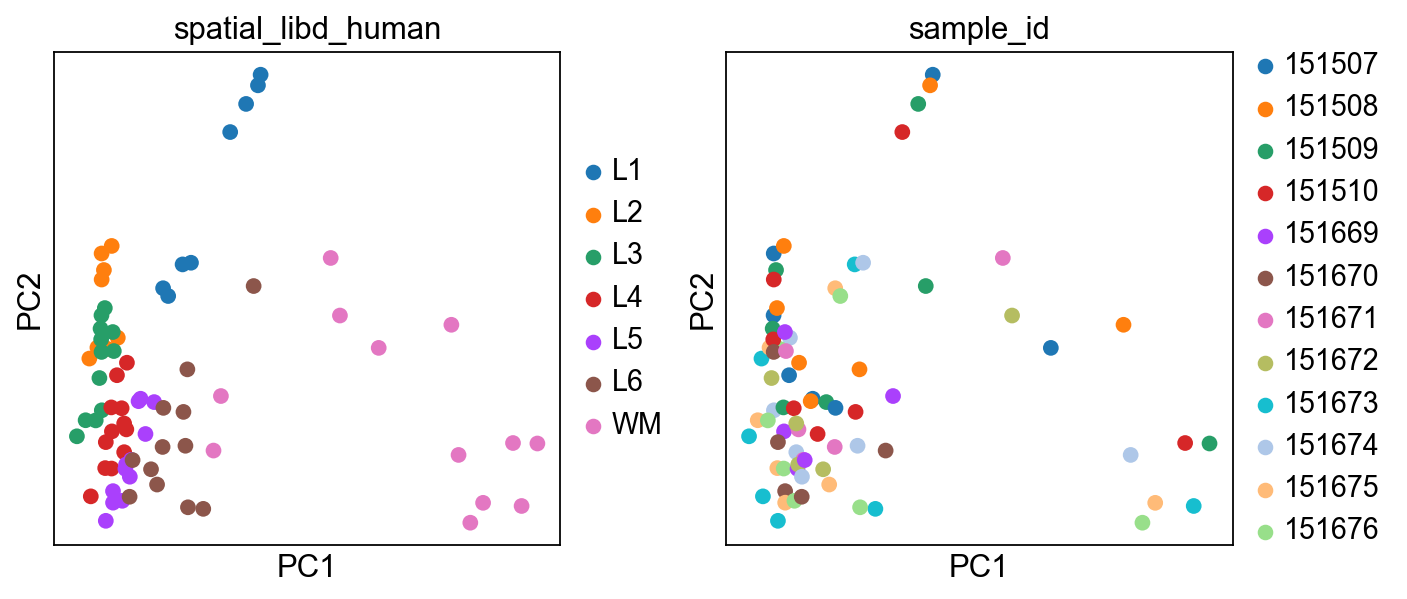

In [15]:
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    adata_cond = adata_merged[adata_merged.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

Scale data

In [16]:
scaled_adata_list = list()

for sample in adata_merged.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_merged[adata_merged.obs['sample_id'] == sample], copy=True))

adata_pb_merged_norm = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
adata_pb_merged_norm

AnnData object with n_obs × n_vars = 170 × 14611
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p'
    layers: 'psbulk_props'

In [17]:
adata_pb_merged_norm.write_h5ad("results/adults_mammals_zscore_norm.h5ad")

computing PCA
    with n_comps=34
    finished (0:00:00)


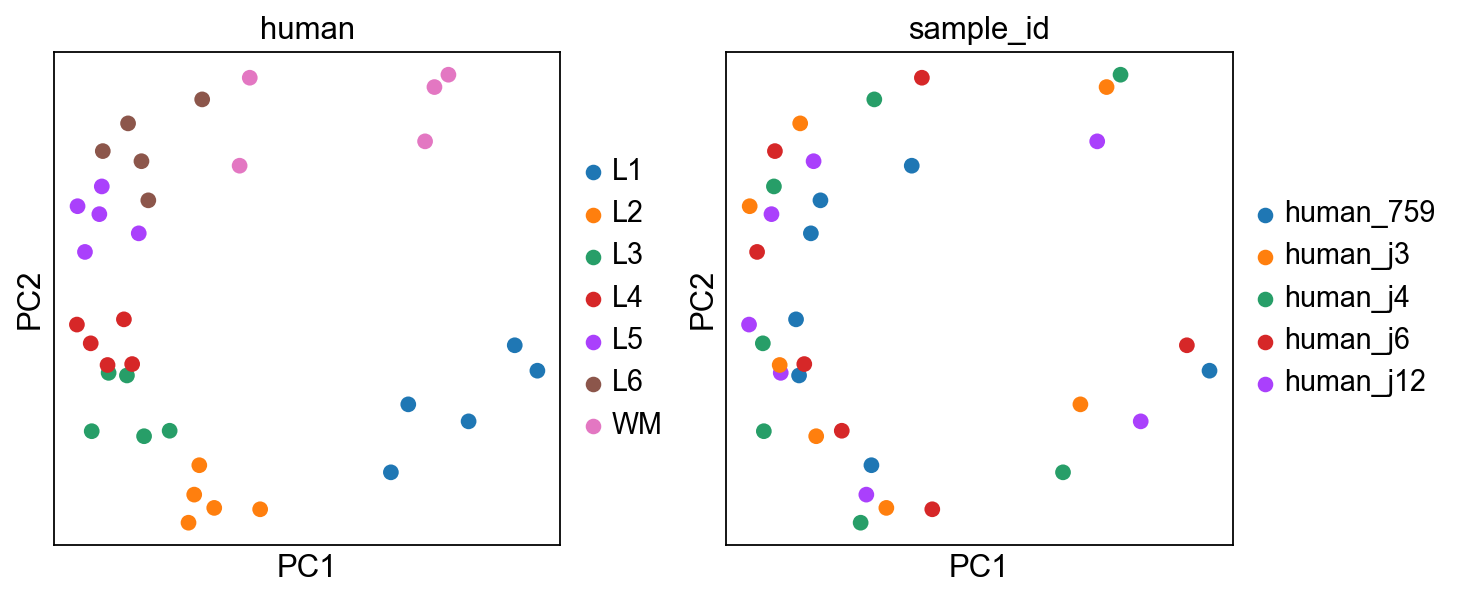

computing PCA
    with n_comps=30
    finished (0:00:00)


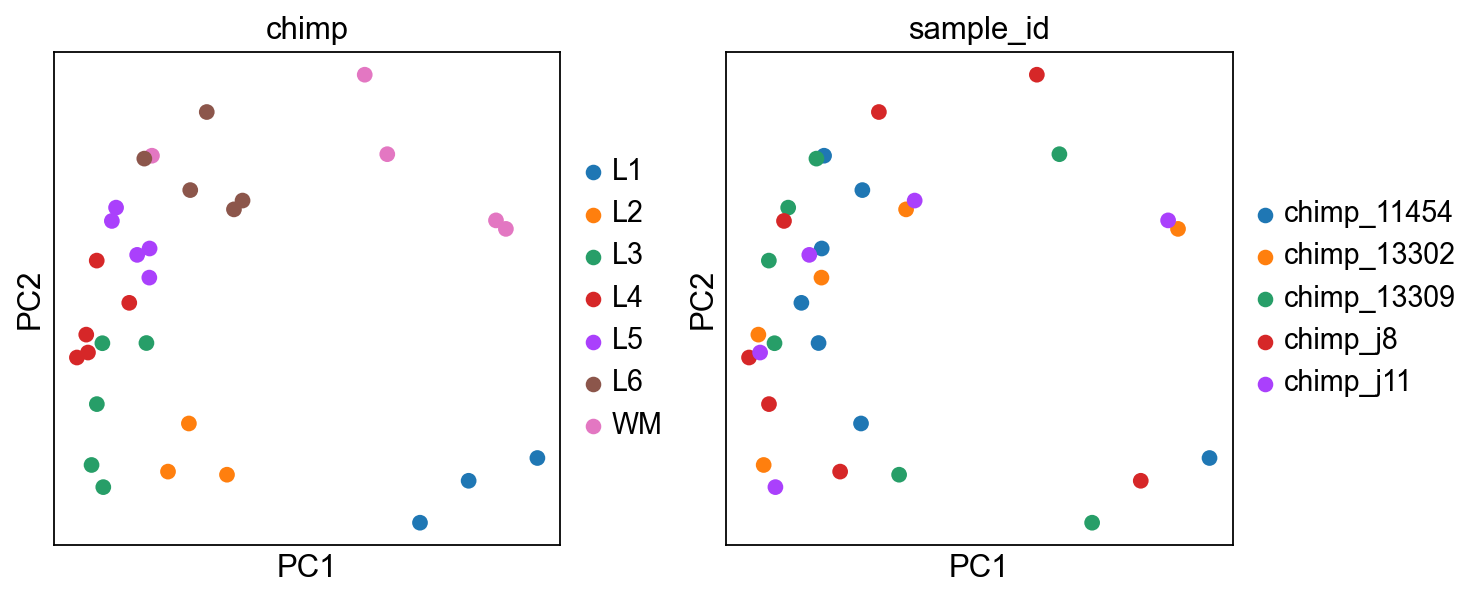

computing PCA
    with n_comps=27
    finished (0:00:00)


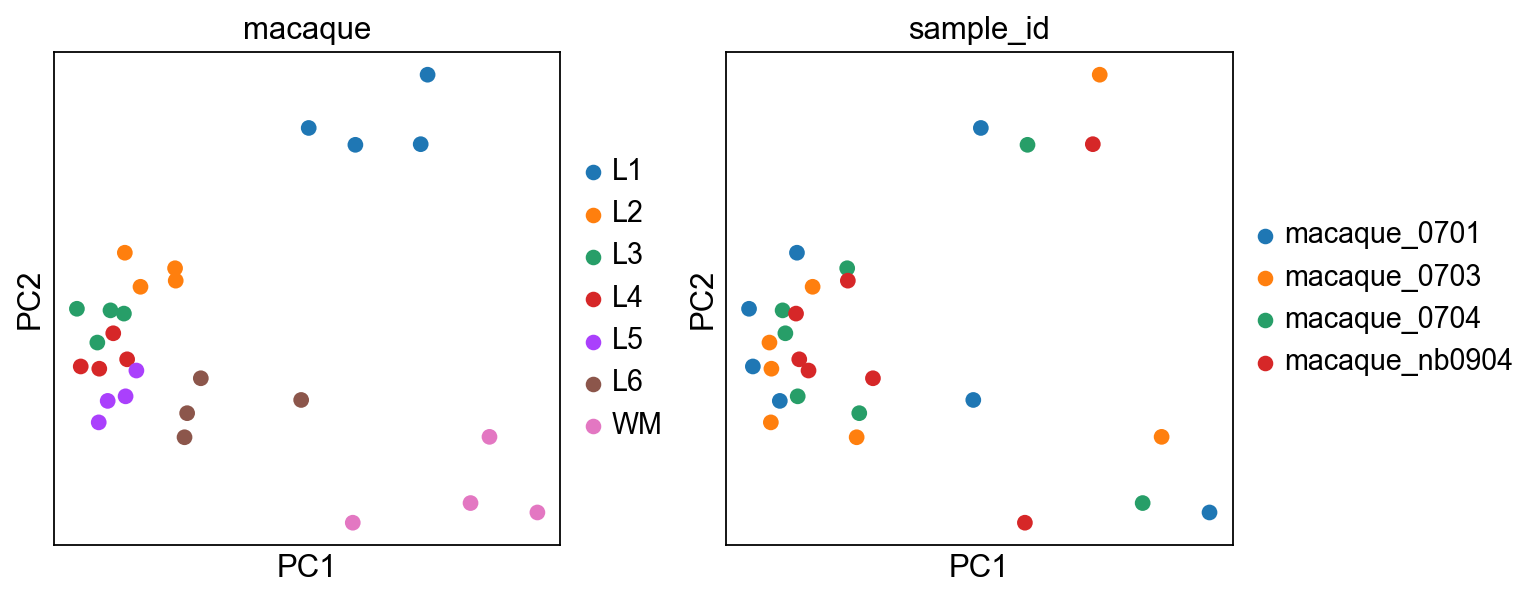

computing PCA
    with n_comps=50
    finished (0:00:00)


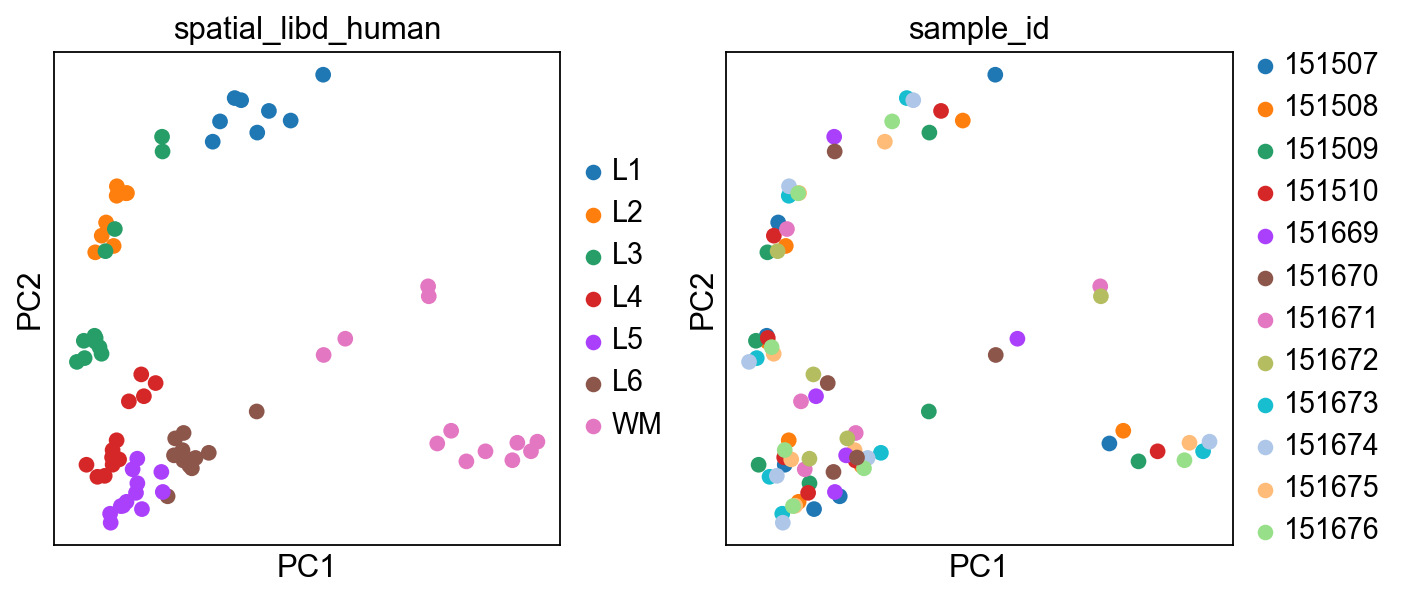

In [18]:
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    adata_cond = adata_pb_merged_norm[adata_pb_merged_norm.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

computing PCA
    with n_comps=50
    finished (0:00:00)


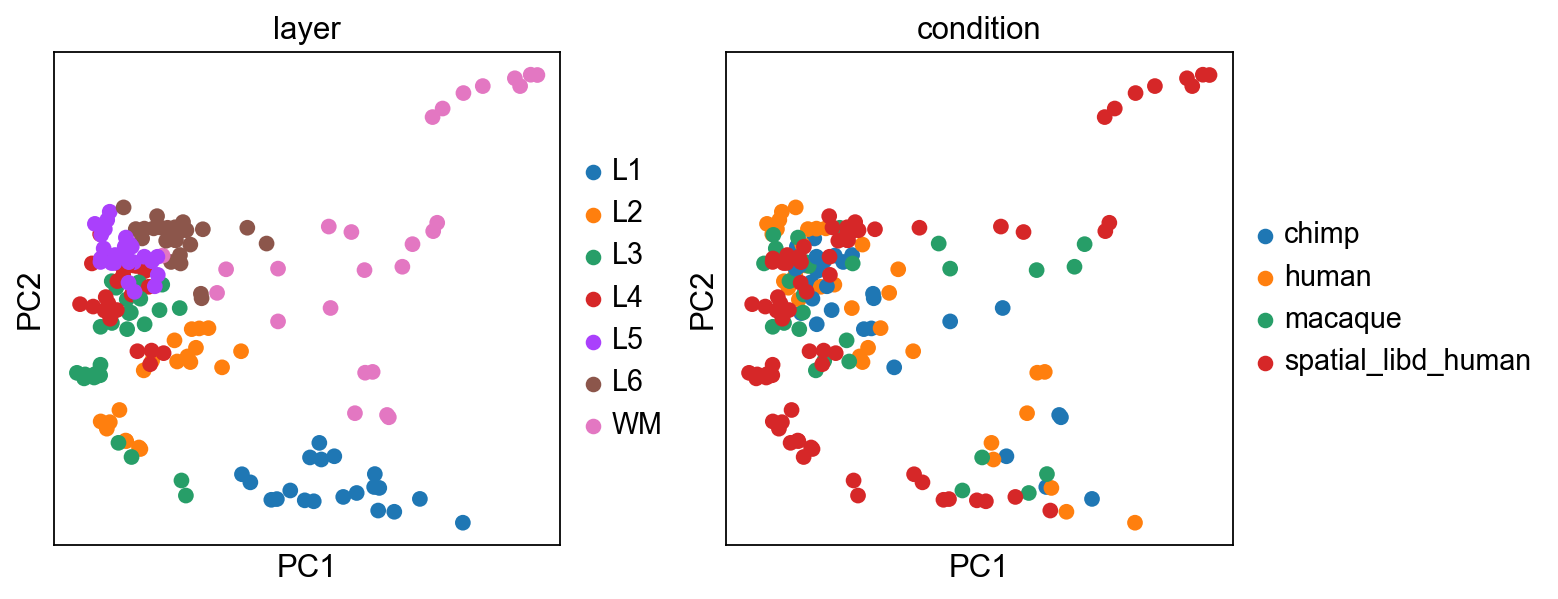

In [19]:
sc.pp.pca(adata_pb_merged_norm)
sc.pl.pca(adata_pb_merged_norm, color=['layer', 'condition'], size=200, ncols=2)

## Specie-specific genes

In [20]:
from statsmodels.stats.multitest import multipletests
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('../results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('../results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('../results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

,logFC.spline_1.human,logFC.spline_2.human,logFC.spline_3.human,logCPM,F,PValue,p_val_adj
A1BG,0.244038,0.286535,0.252427,8.937955,1.353039,0.266747,0.847434
AACS,-0.388070,-0.241365,-0.039750,8.898749,1.925657,0.131096,0.624955
AADAT,-0.399771,-0.369816,-0.361727,8.822620,0.269978,0.846744,1.000000
AAGAB,0.086928,0.361438,0.044400,8.837510,0.579746,0.630315,1.000000
AAK1,0.231119,0.421302,0.032839,8.977608,0.409947,0.746269,1.000000


In [21]:
sign_genes = lambda df: df[df.p_val_adj < 0.05].index
sign_genes_dict = {key:sign_genes(df) for key, df in res_dict.items()}
sign_genes_dict

{'human-chimp': Index(['ACTN2', 'ADGRB2', 'ADGRG1', 'ADGRL1', 'ALCAM', 'AMZ2', 'ANK3', 'AP2S1',
        'APBA1', 'APBA2',
        ...
        'UQCRB', 'UQCRH', 'VAT1L', 'WDR37', 'WLS', 'ZBTB18', 'ZBTB46',
        'ZCCHC17', 'ZMYND8', 'ZNF706'],
       dtype='object', length=224),
 'human-macaque': Index(['AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCC5', 'ABCD3',
        'ABCD4', 'ABHD10',
        ...
        'ZNF483', 'ZNF536', 'ZNF579', 'ZNF706', 'ZNF770', 'ZNF791', 'ZNHIT3',
        'ZRANB2', 'ZYG11B', 'ZYX'],
       dtype='object', length=2141),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9',
        'ACHE', 'ACOT7',
        ...
        'YPEL5', 'YWHAB', 'YWHAG', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZFAND5',
        'ZMPSTE24', 'ZNF536', 'ZNF655'],
       dtype='object', length=1057)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [22]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RBIS', 'RGS2', 'SCN3B', 'SEPTIN6',
        'ST3GAL5', 'SULF2', 'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1',
        'VAT1L', 'ZBTB18', 'ZBTB46', 'ZNF706'],
       dtype='object'),
 65)

In [23]:
background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7790

## Fit splines

In [24]:
df = pd.DataFrame(adata_pb_merged_norm.X, index=adata_pb_merged_norm.obs_names, columns=adata_pb_merged_norm.var_names)

In [25]:
common_hs_genes = df.columns.intersection(hs_genes)
common_hs_genes

Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
       'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
       'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
       'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
       'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
       'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
       'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RGS2', 'SCN3B', 'ST3GAL5', 'SULF2',
       'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1', 'VAT1L', 'ZBTB18',
       'ZBTB46', 'ZNF706'],
      dtype='object')

In [27]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', '151']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_laminar + order_wm
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['151']
df = df.loc[sample_order['all']]
df_hs = df[common_hs_genes].copy()

In [28]:
df_annotation = df.copy()
df_annotation['layer'] = adata_pb_merged_norm.obs.layer
df_annotation['condition'] = adata_pb_merged_norm.obs.condition

In [29]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

A1BG      A1CF     A2ML1    A4GALT      AAAS      AACS  \
condition layer                                                               
chimp     L1    -0.135594 -0.125988  0.230837  0.000000  0.647643 -0.865560   
          L2    -0.599969 -0.125988  0.186253  0.000000 -0.234791 -1.233792   
          L3     1.363364  0.453557 -0.488498 -0.089443 -0.253248 -0.248184   
          L4     0.806634 -0.075593 -0.181285 -0.089443  0.238491  0.716260   
          L5    -0.045450 -0.075593 -0.555914  0.357771 -0.699138  0.658529   

                    AADAC  AADACL3     AADAT     AAGAB  ...    ZSWIM9  \
condition layer                                         ...             
chimp     L1    -0.125988      0.0  0.276943  0.150639  ... -1.259188   
          L2    -0.125988      0.0 -0.000416  0.099635  ...  0.985260   
          L3    -0.075593      0.0  0.924542 -0.019636  ... -0.094803   
          L4    -0.075593      0.0  0.440897  0.563897  ...  0.227199   
          L5    -0.075593      0.0 -0.146682 -0.240033  ...  0.082567   

                     ZUP1      ZW10    ZWILCH     ZWINT      ZXDC  ZYG11A  \
condition layer                                                             
chimp     L1    -1.020733 -0.155936 -0.026675  0.056966  0.792759     0.0   
          L2     0.383069 -0.837427 -0.332539  0.731317 -0.134833     0.0   
          L3     0.094886 -0.212722  0.064277  0.351604 -0.153727     0.0   
          L4    -0.075621 -0.028779  0.058823  0.189963  0.181004     0.0   
          L5    -0.081173  0.337358 -0.756845 -0.195368  0.011822     0.0   

                   ZYG11B       ZYX     ZZEF1  
condition layer                                
chimp     L1    -0.874062  0.251207 -0.617939  
          L2     0.000144 -0.646506  0.227042  
          L3     0.061983  0.478632 -0.293642  
          L4     0.014626  0.537519  0.068318  
          L5    -0.103715  0.016625 -0.000613  

[5 rows x 14611 columns]

In [30]:
df_cont = df_annotation.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [31]:
df_cont.to_csv('results/zscore_norm_expr_adults_mammals.csv')

In [32]:
from scipy.interpolate import UnivariateSpline

grid = np.linspace(1, 7, 400)
array = np.zeros((grid.size, len(common_hs_genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(common_hs_genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=common_hs_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

In [33]:
df_spline.to_csv('results/hs_norm_splines_adults_mammals.csv')